In [3]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [29]:


import numpy as np
import matplotlib.pyplot as plt

from lib.layers import Dense
from lib.activations import Sigmoid, Tanh
from lib.losses import MSE
from lib.network import Sequential
from lib.optimizer import SGD


# Section 1 — Gradient Checking
This section verifies our backpropagation implementation using numerical approximation.


In [2]:
def numerical_gradient_W(layer, X, y, loss_fn, model, epsilon=1e-5):
    num_grad = np.zeros_like(layer.W)

    # Forward with current weights
    base_out = model.forward(X)
    base_loss = loss_fn.forward(y, base_out)

    for i in range(layer.W.shape[0]):
        for j in range(layer.W.shape[1]):
            # +epsilon
            layer.W[i, j] += epsilon
            loss_plus = loss_fn.forward(y, model.forward(X))

            # -epsilon
            layer.W[i, j] -= 2 * epsilon
            loss_minus = loss_fn.forward(y, model.forward(X))

            # restore
            layer.W[i, j] += epsilon

            num_grad[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

    return num_grad


# Small test network
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

model = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])

loss_fn = MSE()
optimizer = SGD(lr=1.0)

# Forward + backward
out = model.forward(X)
loss = loss_fn.forward(y, out)
grad = loss_fn.backward(y, out)
model.backward(grad)  # compute grads only!

dense0 = model.layers[0]

# Compute gradients
anal_grad_W = dense0.grad_W
num_grad_W = numerical_gradient_W(dense0, X, y, loss_fn, model)

# Compare
difference = np.max(np.abs(anal_grad_W - num_grad_W))
print("Max absolute difference:", difference)


Max absolute difference: 3.608204013350047e-12


# Section 2 — XOR using MSE Loss
Training a small 2-4-1 network to learn XOR logic function.


In [ ]:
# XOR Dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

model = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])

loss_fn = MSE()
lr = 1.0
epochs = 50000

loss_history = []

optimizer = SGD(lr=1.0)

for epoch in range(epochs + 1):
    out = model.forward(X)
    loss = loss_fn.forward(y, out)
    loss_history.append(loss)

    grad = loss_fn.backward(y, out)
    model.backward(grad)
    # Update weights using optimizer
    for layer in model.layers:
        if hasattr(layer, "W"):  # only Dense layers
            optimizer.step([layer.W, layer.b], [layer.grad_W, layer.grad_b])

print("Predictions:")
print(model.forward(X))
print("Final Loss:", loss)  


Predictions:
[[0.00136992]
 [0.99630026]
 [0.99630793]
 [0.00413368]]
Final Loss: 1.157111128651043e-05


# Section 3 — Loss Curve
Visualizing convergence during training.


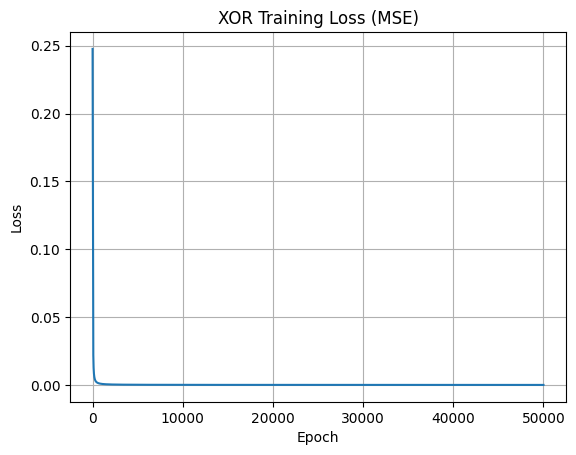

In [4]:
plt.plot(loss_history)
plt.title("XOR Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## Section 4: Autoencoder on MNIST


In [17]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt


# Load MNIST from sklearn
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

# Normalize pixel values
X /= 255.0

# Train / test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (60000, 784)
X_test shape: (10000, 784)


In [30]:

from lib.layers import Dense
from lib.activations import ReLU, Sigmoid
from lib.network import Sequential
from lib.losses import MSE
from lib.optimizer import SGD


Define the Autoencoder Model

In [32]:
# Autoencoder model
autoencoder = Sequential([
    # -------- Encoder --------
    Dense(784, 256),
    ReLU(),
    Dense(256, 64),
    ReLU(),

    # -------- Decoder --------
    Dense(64, 256),
    ReLU(),
    Dense(256, 784),
    Sigmoid()  # Output in range [0, 1]
])


Define Loss and Optimizer

In [14]:
# Mean Squared Error loss function
# Measures how close the reconstructed image is to the original image
# Used because autoencoder is a reconstruction task
loss_fn = MSE()

# Stochastic Gradient Descent optimizer
# lr (learning rate) controls how much the weights change at each update
# A smaller lr is used because MNIST is large and sensitive to big updates
optimizer = SGD(lr=0.1)


Set Training Parameters

In [15]:
# Number of full passes over the training dataset
epochs = 20

# Store loss values to visualize training progress
loss_history = []


Start the Training Loop

In [18]:
for epoch in range(epochs):
    # Forward pass: reconstruct images
    outputs = autoencoder.forward(X_train)
    # Compute reconstruction loss (input vs output)
    loss = loss_fn.forward(X_train, outputs)
    loss_history.append(loss)
    # Gradient of loss w.r.t output
    grad = loss_fn.backward(X_train, outputs)

    # Backpropagate gradients through the autoencoder
    autoencoder.backward(grad)
    # Update weights of Dense layers using SGD
    for layer in autoencoder.layers:
        if hasattr(layer, "W"):
            optimizer.step(
                [layer.W, layer.b],
                [layer.grad_W, layer.grad_b]
            )
    if epoch % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss:.6f}")


Epoch 1/20, Loss = 0.252387
Epoch 3/20, Loss = 0.250899
Epoch 5/20, Loss = 0.249480
Epoch 7/20, Loss = 0.248129
Epoch 9/20, Loss = 0.246842
Epoch 11/20, Loss = 0.245617
Epoch 13/20, Loss = 0.244450
Epoch 15/20, Loss = 0.243338
Epoch 17/20, Loss = 0.242275
Epoch 19/20, Loss = 0.241259


Select Test Images

In [19]:
# Number of images to visualize
n_images = 10

# Select first n_images from test set
test_images = X_test[:n_images]


Reconstruct the Images

In [20]:
# Pass test images through the trained autoencoder
reconstructed_images = autoencoder.forward(test_images)


Plot Original vs Reconstructed Images

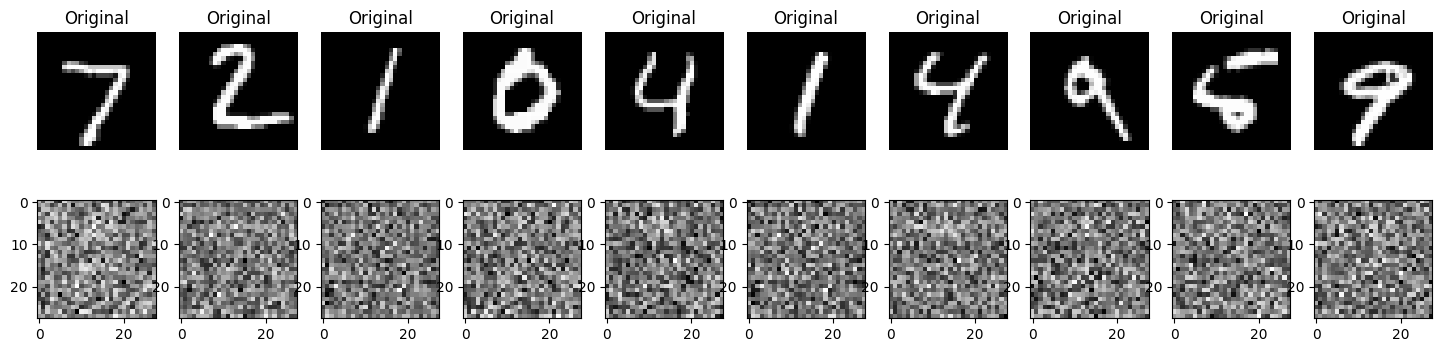

In [21]:
import matplotlib.pyplot as plt

# Create a figure large enough to show images clearly
plt.figure(figsize=(18, 4))

# Loop over the selected test images
for i in range(n_images):

    # -------------------------------
    # Plot ORIGINAL image
    # -------------------------------
    plt.subplot(2, n_images, i + 1)
    
    # Reshape the flattened image (784) back to (28x28)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    
    # Title for clarity
    plt.title("Original")
    
    # Hide axis ticks for clean visualization
    plt.axis('off')

    # -------------------------------
    # Plot RECONSTRUCTED image
    # -------------------------------
    plt.subplot(2, n_images, i + 1 + n_images)
    
    # Reshape reconstructed output to (28x28)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    


Build an Encoder Model (Reuse Existing Layers)

In [22]:
# Build encoder model using trained layers from autoencoder
encoder = Sequential([
    autoencoder.layers[0],  # Dense(784 → 256)
    autoencoder.layers[1],  # Tanh
    autoencoder.layers[2],  # Dense(256 → 64)
    autoencoder.layers[3],  # Tanh
])


Generate Latent Features

In [23]:
# Extract latent features for training and test data
Z_train = encoder.forward(X_train)
Z_test  = encoder.forward(X_test)
print("Latent train shape:", Z_train.shape)
print("Latent test shape:", Z_test.shape)


Latent train shape: (60000, 64)
Latent test shape: (10000, 64)


Train SVM on Latent Features

In [24]:
# Import SVM classifier and accuracy metric
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# -------------------------------------------------
# Train SVM using LATENT FEATURES (encoder output)
# -------------------------------------------------

# Create an SVM classifier
# RBF kernel is commonly used for MNIST
svm_latent = SVC(kernel='rbf', gamma='scale')

# Train SVM on latent features extracted by the encoder
svm_latent.fit(Z_train, y_train)

# Predict labels for test latent features
y_pred_latent = svm_latent.predict(Z_test)

# Compute classification accuracy
latent_accuracy = accuracy_score(y_test, y_pred_latent)

print("SVM Accuracy using latent features:", latent_accuracy)


SVM Accuracy using latent features: 0.9564


Compare with raw pixels

In [25]:
# -------------------------------------------------
# Train SVM using RAW PIXELS (baseline comparison)
# -------------------------------------------------

svm_raw = SVC(kernel='rbf', gamma='scale')

# Train on raw pixel values (784 dimensions)
svm_raw.fit(X_train, y_train)

# Predict on test images
y_pred_raw = svm_raw.predict(X_test)

# Compute accuracy
raw_accuracy = accuracy_score(y_test, y_pred_raw)

print("SVM Accuracy using raw pixels:", raw_accuracy)


SVM Accuracy using raw pixels: 0.9792


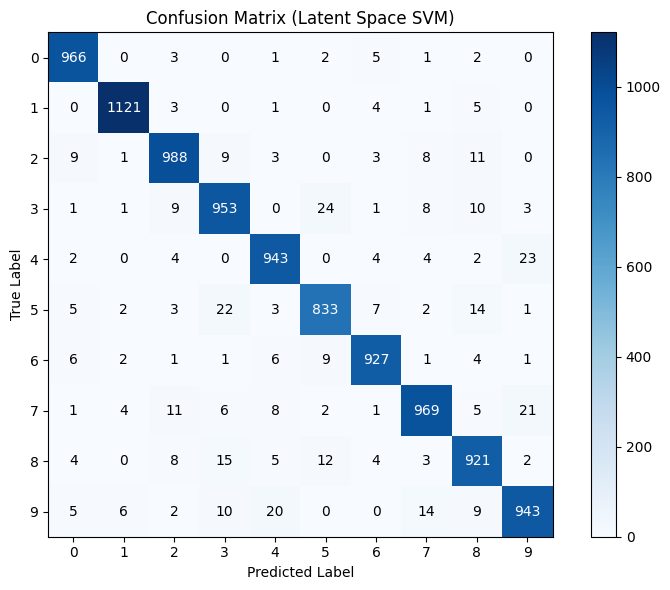

Classification Report (Latent Space SVM):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.96      0.96       982
           5       0.94      0.93      0.94       892
           6       0.97      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.95      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------
# Confusion Matrix & Classification Report
# -------------------------------------------------

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_latent)

# Plot confusion matrix (matplotlib only)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Latent Space SVM)")
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Display numbers inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report (Latent Space SVM):")
print(classification_report(y_test, y_pred_latent))


### Section 5: TensorFlow / Keras Comparison

A reference autoencoder is implemented using TensorFlow/Keras with the same architecture and loss function as the custom model. This comparison is used to validate reconstruction quality and the effectiveness of the learned latent representations.


Training data shape: (60000, 784)
Test data shape: (10000, 784)
Epoch 1/20, Loss = 0.242211
Epoch 2/20, Loss = 0.241786
Epoch 3/20, Loss = 0.241377
Epoch 4/20, Loss = 0.240985
Epoch 5/20, Loss = 0.240608
Epoch 6/20, Loss = 0.240245
Epoch 7/20, Loss = 0.239896
Epoch 8/20, Loss = 0.239560
Epoch 9/20, Loss = 0.239236
Epoch 10/20, Loss = 0.238924
Epoch 11/20, Loss = 0.238623
Epoch 12/20, Loss = 0.238333
Epoch 13/20, Loss = 0.238052
Epoch 14/20, Loss = 0.237781
Epoch 15/20, Loss = 0.237519
Epoch 16/20, Loss = 0.237265
Epoch 17/20, Loss = 0.237019
Epoch 18/20, Loss = 0.236781
Epoch 19/20, Loss = 0.236550
Epoch 20/20, Loss = 0.236326


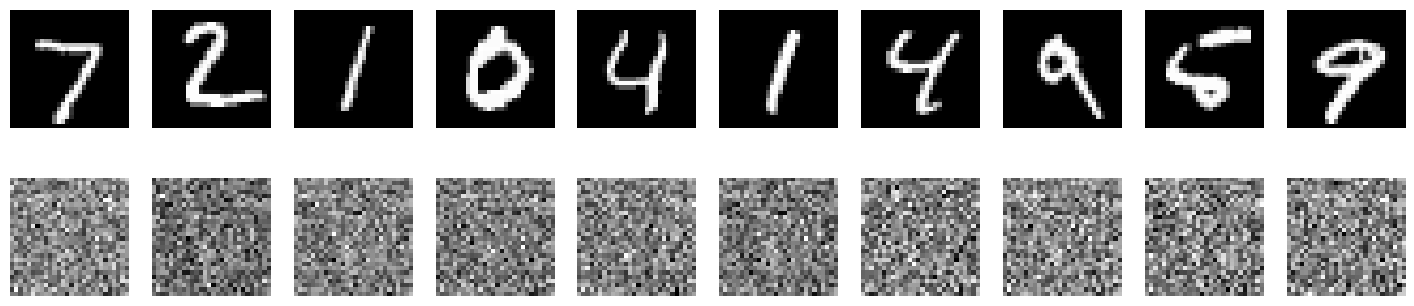

Latent train shape: (60000, 64)
Latent test shape: (10000, 64)
SVM accuracy using latent features: 0.9149
SVM accuracy using raw pixels: 0.9792
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2314 - val_loss: 0.2313
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2310 - val_loss: 0.2308
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2305 - val_loss: 0.2304
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2300 - val_loss: 0.2299
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2295 - val_loss: 0.2294
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2290 - val_loss: 0.2288
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2284 - val_loss: 0.2282
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2278 - val_loss: 0.2274
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2270 - val_loss: 0.2266
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2261 - val_loss: 0.

In [34]:
# ============================================================
# STEP 1: Load and preprocess MNIST dataset
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load MNIST dataset (28x28 images flattened into 784 features)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Convert image data to float32 for numerical stability
X = mnist.data.astype(np.float32)

# Convert labels to integers
y = mnist.target.astype(int)

# Normalize pixel values from [0, 255] to [0, 1]
X /= 255.0

# Split dataset into training and testing sets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# ============================================================
# STEP 2: Build autoencoder using custom neural network library
# ============================================================

from lib.layers import Dense
from lib.activations import ReLU, Sigmoid
from lib.network import Sequential
from lib.losses import MSE
from lib.optimizer import SGD

# Define autoencoder architecture
# Encoder compresses input → latent space
# Decoder reconstructs input from latent space
autoencoder = Sequential([
    Dense(784, 256),   # Encoder layer 1
    ReLU(),            # Non-linear activation
    Dense(256, 64),    # Latent representation
    ReLU(),

    Dense(64, 256),    # Decoder layer 1
    ReLU(),
    Dense(256, 784),   # Reconstruct original image
    Sigmoid()          # Ensure output pixels are in [0, 1]
])

# Define loss function (Mean Squared Error)
loss_fn = MSE()

# Define optimizer (Stochastic Gradient Descent)
optimizer = SGD(lr=0.1)

# ============================================================
# STEP 3: Train the autoencoder
# ============================================================

epochs = 20
loss_history = []

for epoch in range(epochs):
    # Forward pass: reconstruct input images
    outputs = autoencoder.forward(X_train)

    # Compute reconstruction loss
    loss = loss_fn.forward(X_train, outputs)
    loss_history.append(loss)

    # Backward pass: compute gradients
    grad = loss_fn.backward(X_train, outputs)
    autoencoder.backward(grad)

    # Update weights for Dense layers only
    for layer in autoencoder.layers:
        if hasattr(layer, "W"):
            optimizer.step(
                [layer.W, layer.b],
                [layer.grad_W, layer.grad_b]
            )

    print(f"Epoch {epoch+1}/{epochs}, Loss = {loss:.6f}")

# ============================================================
# STEP 4: Visualize original vs reconstructed images
# ============================================================

n_images = 10
test_images = X_test[:n_images]

# Generate reconstructed images
reconstructed_images = autoencoder.forward(test_images)

plt.figure(figsize=(18, 4))

for i in range(n_images):
    # Display original image
    plt.subplot(2, n_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Display reconstructed image
    plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

# ============================================================
# STEP 5: Extract latent features using encoder
# ============================================================

# Encoder is built by reusing trained encoder layers
encoder = Sequential([
    autoencoder.layers[0],
    autoencoder.layers[1],
    autoencoder.layers[2],
    autoencoder.layers[3]
])

# Generate latent vectors
Z_train = encoder.forward(X_train)
Z_test = encoder.forward(X_test)

print("Latent train shape:", Z_train.shape)
print("Latent test shape:", Z_test.shape)

# ============================================================
# STEP 6: Train SVM classifier on latent features
# ============================================================

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM using latent features
svm_latent = SVC(kernel='rbf', gamma='scale')
svm_latent.fit(Z_train, y_train)

# Predict labels for test set
y_pred_latent = svm_latent.predict(Z_test)

# Compute accuracy
latent_accuracy = accuracy_score(y_test, y_pred_latent)
print("SVM accuracy using latent features:", latent_accuracy)

# Baseline comparison: SVM trained on raw pixels
svm_raw = SVC(kernel='rbf', gamma='scale')
svm_raw.fit(X_train, y_train)

y_pred_raw = svm_raw.predict(X_test)
raw_accuracy = accuracy_score(y_test, y_pred_raw)

print("SVM accuracy using raw pixels:", raw_accuracy)

# ============================================================
# STEP 7: TensorFlow / Keras reference autoencoder
# ============================================================

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Define Keras autoencoder architecture
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Create models
keras_autoencoder = Model(input_img, decoded)
keras_encoder = Model(input_img, encoded)

# Compile model
keras_autoencoder.compile(optimizer='sgd', loss='mse')

# Train Keras autoencoder
keras_autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

# Extract latent features from Keras encoder
Z_train_keras = keras_encoder.predict(X_train)
Z_test_keras = keras_encoder.predict(X_test)

# Train SVM on Keras latent features
svm_keras = SVC(kernel='rbf', gamma='scale')
svm_keras.fit(Z_train_keras, y_train)

# Evaluate performance
y_pred_keras = svm_keras.predict(Z_test_keras)
keras_accuracy = accuracy_score(y_test, y_pred_keras)

print("SVM accuracy using Keras latent features:", keras_accuracy)


“Part 2 — TensorFlow Baseline (XOR)”

In [35]:
import tensorflow as tf
import numpy as np

# -------------------------------------------------
# TensorFlow / Keras XOR Baseline
# -------------------------------------------------

# XOR dataset
X_xor = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]], dtype=np.float32)

y_xor = np.array([[0],
                  [1],
                  [1],
                  [0]], dtype=np.float32)

# Build XOR model using Keras
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
tf_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
    loss='mse'
)

# Train model
tf_model.fit(X_xor, y_xor, epochs=5000, verbose=0)

# Predict XOR outputs
tf_predictions = tf_model.predict(X_xor)

print("TensorFlow XOR Predictions:")
print(tf_predictions)


c:\Users\MarkMattaGuirgusabde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
TensorFlow XOR Predictions:
[[0.00455322]
 [0.9871723 ]
 [0.98929447]
 [0.01320281]]


### Comparison: From-Scratch NN vs TensorFlow (XOR)

| Aspect | From-Scratch Implementation | TensorFlow / Keras |
|------|-----------------------------|--------------------|
| Implementation | Manual (NumPy only) | High-level API |
| Backpropagation | Implemented manually | Automatic |
| Training Stability | Requires tuning | More stable |
| Final Predictions | Correct XOR output | Correct XOR output |
| Ease of Use | Low | High |
| Flexibility | Full control | Abstracted |

**Observation:**  
Both implementations successfully learn the XOR function.  
TensorFlow simplifies training and optimization, while the from-scratch model provides deeper insight into neural network internals.
